<a href="https://colab.research.google.com/github/MayibongweEyeMagic/Congo/blob/main/IDVE_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Name: Introduction to Data Visualization and Exploration Assignment 2

## Group Members
1. Member 1: Mayibongwe Bafoly
2. Member 2: Neo Maja
3. Member 3: Siphesihle Mthethwa
4. Member 4: O'neil Sithole


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import os
import csv
import chardet
from pprint import pprint
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import copy
import math
import itertools
import warnings
from unicodedata import normalize
warnings.filterwarnings('ignore')
import re
from collections import defaultdict

#Visualisation Imports
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import statistics
import geopandas as gpd
import osgeo.ogr
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":8})
%matplotlib inline

In [3]:
PREFIX='/content/drive/Shareddrives/IDVE_Assignment2'
paths = {
    'athlete_events': PREFIX + '/athlete_events.csv',
    'athlete_events_data_dictionary': PREFIX + '/athlete_events_data_dictionary.csv',
    'country_defs': PREFIX + '/country_definitions.csv',
    'country_defs_data_dictionary': PREFIX + '/country_definitions_data_dictionary.csv',
    'cleaned_athlete_events': PREFIX + '/cleaned_athlete_events.csv',
    'cleaned_country_defs': PREFIX + '/cleaned_country_defs.csv'
}


In [4]:
# Reading into dataframes
athlete_events_df = pd.read_csv(paths['athlete_events'])
athlete_events_dd_df = pd.read_csv(paths['athlete_events_data_dictionary'])
country_defs_df = pd.read_csv(paths['country_defs'])
country_defs_dd_df = pd.read_csv(paths['country_defs_data_dictionary'])

In [5]:
athlete_events_dd_df

,Field,Description
0,ID,Unique number for each athlete
1,Name,Athlete's name
2,Sex,Male (M) or Female (F)
3,Age,Integer
4,Height,In centimeters
5,Weight,In kilograms
6,Team,Team name
7,NOC,National Olympic Committee 3-letter code
8,Games,Year and season
9,Year,Integer


In [6]:
country_defs_dd_df

,Field,Description
0,NOC,National Olympic Committee 3 letter code
1,region,Country name used for geospatial mapping
2,notes,"Real country name if ""region"" isn't an exact m..."


## 3.1   Removing outliers and bad data





### A)   Removing bad data



We start by typecasting all the fields in both datasets to the correct types as doing so will improve the efficiency and accuracy of our analyses.

In [7]:
# Typecasting fields
athlete_ev_type_map = {
    'ID': 'uint32', 'Name': 'object', 'Sex': 'category', 'Age': 'float32', 'Height': 'float32',
    'Weight': 'float32', 'Team': 'object', 'NOC': 'category', 'Games': 'category', 'Year':'uint32',
    'Season': 'category', 'City': 'object', 'Sport': 'category', 'Event': 'object', 'Medal': 'category'
}

country_defs_type_map = {'NOC': 'category', 'region': 'object', 'notes': 'object'}

athlete_default_vals = {'Age': 0, 'Height': 0, 'Weight': 0, 'Medal': 'None'}

# Athlete events dataset
athlete_events_df.fillna(value=athlete_default_vals, inplace=True)
athlete_events_df = athlete_events_df.astype(athlete_ev_type_map)
athlete_events_df.replace({'Age': {0 : np.nan}, 'Height': {0 : np.nan}, 'Weight': {0 : np.nan}}, inplace=True)

# Country definitions dataset
country_defs_df = country_defs_df.astype(country_defs_type_map)

print(f"Athlete events: \n{athlete_events_df.dtypes}\n")
print(f"Country definitions: \n{country_defs_df.dtypes}")

Athlete events: 
ID          uint32
Name        object
Sex       category
Age        float32
Height     float32
Weight     float32
Team        object
NOC       category
Games     category
Year        uint32
Season    category
City        object
Sport     category
Event       object
Medal     category
dtype: object

Country definitions: 
NOC       category
region      object
notes       object
dtype: object


The following is a dictionary that maps NOCs that are now obsolete (no longer appear on the IOC results database) to their replacements.

In [8]:
# Defining obsolete NOCs
obsolete_nocs = {
    "BIR" : "MYA",
    "CEY" : "SIR",
    "DAH" : "BEN",
    "GUI" : "GUY",
    "HBR" : "BIZ",
    "IHO" : "INA",
    "KHM" : "CAM",
    "MAL" : "MAS",
    "NBO" : "MAS",
    "NRH" : "ZAM",
    "RHO" : "ZIM",
    "SAA" : "FRG",
    "UAR" : "EGY",
    "VOL" : "BUR",
    "WSM" : "SAM",
    "YAR" : "YEM",
    "YMD" : "YEM",
    "ZAI" : "COD",
    "SIN" : "SGP",
    "URS" : "RUS",
    "NFL" : "CAN",
    "FRG" : "GER",
    "GDR" : "GER",
    "BOH" : "CZE",
    "TCH" : "CZE",
    "ANZ" : "AUS",
    "CRT" : "GRE",
    "SCG" : "SRB",
    "YUG" : "SRB",
    "VNM" : "VIE"
}

We now use the above dictionary to replace obsolete NOCs in the country definitions dataset and subsequently remove any duplicates that arise. As can be seen from the results 17 duplicates have been removed.

In [9]:
# Cleaning the datasets
# - Country definitions (removing obsolete NOCs)
print(f"Length before cleaning: {len(country_defs_df)}")

country_defs_df = country_defs_df.replace({"NOC": obsolete_nocs})
country_defs_df.replace({"region": {"Boliva": "Bolivia"}}, inplace=True)
country_defs_df.drop_duplicates(subset=["NOC", "region"], inplace=True)

print(f"Length after cleaning: {len(country_defs_df)}")

Length before cleaning: 230
Length after cleaning: 213


We then use the updated country definitions dataset to remove records with non-existent NOCs from the athlete events dataset. The results show that all the records contain valid NOCs.

In [10]:
# - Athlete events (removing non-existent NOCs)
print(f"Length before cleaning: {len(athlete_events_df)}")

athlete_events_df = athlete_events_df.replace({"NOC": obsolete_nocs})
valid_nocs = country_defs_df["NOC"].unique()
athlete_events_df = athlete_events_df[athlete_events_df["NOC"].isin(valid_nocs)]

print(f"Length after cleaning: {len(athlete_events_df)}")

Length before cleaning: 271116
Length after cleaning: 271116


In order to identify records in the athlete events dataset that contain olympic events that never occured (either by year, country or city) we first load a table of olympic games as a dataframe from wikipedia. This table has a comprehensive list of olympic games and their host cities dating back to the first ever hosted olympic games in 1896. We remove records that contain cancelled olympic games and only extract the city, country, year and region fields.

In [11]:
# - Athlete events (removing olympic events that never occured)
# Read table of olympic games from wikipedia
olympic_events_df = pd.read_html("https://en.wikipedia.org/wiki/List_of_Olympic_Games_host_cities",
                                 converters={
                                    'City.1': lambda city: re.sub(r"\[.\]", "", city).strip(),
                                    'Country': lambda country: country.strip(),
                                    'Region': lambda region: region.strip(),
                                    'Year': lambda year: int(year.strip())
                                 })[1]

olympic_events_df = olympic_events_df[~olympic_events_df[olympic_events_df.columns[7]].str.contains("Cancelled")]
olympic_events_df.drop([olympic_events_df.columns[0], olympic_events_df.columns[5],
                        olympic_events_df.columns[6], olympic_events_df.columns[7],
                        olympic_events_df.columns[8], olympic_events_df.columns[9]], axis=1, inplace=True)
olympic_events_df.rename(columns={'City.1': 'City'}, inplace=True)
olympic_events_df.head(10)

,City,Country,Year,Region
0,Athens,Greece,1896,Europe
1,Paris,France,1900,Europe
2,St. Louis,United States,1904,North America
3,London,United Kingdom,1908,Europe
4,Stockholm,Sweden,1912,Europe
6,Antwerp,Belgium,1920,Europe
7,Chamonix,France,1924,Europe
8,Paris,France,1924,Europe
9,St. Moritz,Switzerland,1928,Europe
10,Amsterdam,Netherlands,1928,Europe


Utilising the above table we identity and remove records that contain invalid years from the athlete events dataset. As can be seen from the results there were only 1733 records (which contained the year 1906) that were removed. This is due the fact that the IOC currently does not recognise the Athens 1906 olympic games and does not regard any events that occured there as official.

In [12]:
# Remove years in which olympic events could not have occured
print(f"Length before cleaning: {len(athlete_events_df)}")

invalid_years = athlete_events_df[~athlete_events_df["Year"].isin(olympic_events_df["Year"].unique())]["Year"].unique()
athlete_events_df = athlete_events_df[athlete_events_df["Year"].isin(olympic_events_df["Year"].unique())]

print(f"Length after cleaning: {len(athlete_events_df)}")
print(f"Years removed: {invalid_years.tolist()}")

Length before cleaning: 271116
Length after cleaning: 269383
Years removed: [1906]


Since some city names seem to be mislabelled, we now use the table to rectify them by applying a replacement that maps each year to the correct city name. As a result, all the records now contain valid cities and years.

In [13]:
# Correct city names (map year to correct city)
incorrect_cities = athlete_events_df[~athlete_events_df["City"].isin(olympic_events_df["City"].unique())]
print(f"Number of rows with incorrect/invalid cities before: {len(incorrect_cities)}")
display(incorrect_cities.head(10))

year_city_map = dict(zip(olympic_events_df["Year"], olympic_events_df["City"]))
athlete_events_df["City"] = athlete_events_df.apply(lambda row: year_city_map[row["Year"]], axis=1)

print()
incorrect_cities = athlete_events_df[~athlete_events_df["City"].isin(olympic_events_df["City"].unique())]
print(f"Number of rows with incorrect/invalid cities after: {len(incorrect_cities)}")
display(incorrect_cities)

Number of rows with incorrect/invalid cities before: 44293


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
37,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze
77,20,Kjetil Andr Aamodt,M,34.0,176.0,85.0,Norway,NOR,2006 Winter,2006,Winter,Torino,Alpine Skiing,Alpine Skiing Men's Downhill,None
78,20,Kjetil Andr Aamodt,M,34.0,176.0,85.0,Norway,NOR,2006 Winter,2006,Winter,Torino,Alpine Skiing,Alpine Skiing Men's Super G,Gold
82,23,Fritz Aanes,M,26.0,187.0,89.0,Norway,NOR,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Light-Heavyweight, Greco-Roman",None
86,25,Alf Lied Aanning,M,24.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Gymnastics,"Gymnastics Men's Team All-Around, Free System",Silver
106,38,Karl Jan Aas,M,20.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Gymnastics,"Gymnastics Men's Team All-Around, Free System",Silver
116,41,Rolf Aas,M,28.0,NaN,NaN,Norway,NOR,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
128,46,Hans Aasns,M,53.0,194.0,93.0,Norway,NOR,1956 Summer,1956,Summer,Melbourne,Shooting,Shooting Men's Trap,None



Number of rows with incorrect/invalid cities after: 0


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal


### B) Removing outliers

In [14]:
# Plots ditributions for Age, Weight and Height
def plot_dists(df):
    fig, ax = plt.subplots(1, 3, figsize=(13, 4))

    sns.kdeplot(df["Age"], shade=True, ax=ax[0])
    ax[0].set_title("Age distribution")
    sns.kdeplot(data=df, x="Weight", hue="Sex", shade=True, ax=ax[1])
    ax[1].set_title("Weight distribution")
    sns.kdeplot(data=df, x="Height", hue="Sex", shade=True, ax=ax[2])
    ax[2].set_title("Height distribution")

    plt.tight_layout()

    plt.show()

In order to identify the appropriate method to use for outlier detection, we first plot the distributions of the age, weight and height values. If the distribution is skewed (like it is for age and weight) we will use the 1.5 * IQR rule which states that any values lying below the 1st quartile - 1.5 * IQR as well as values lying above the 3rd quartile + 1.5 * IQR are outliers. For the height values we will use the standard deviation to identify outliers (since the values are normally distributed).

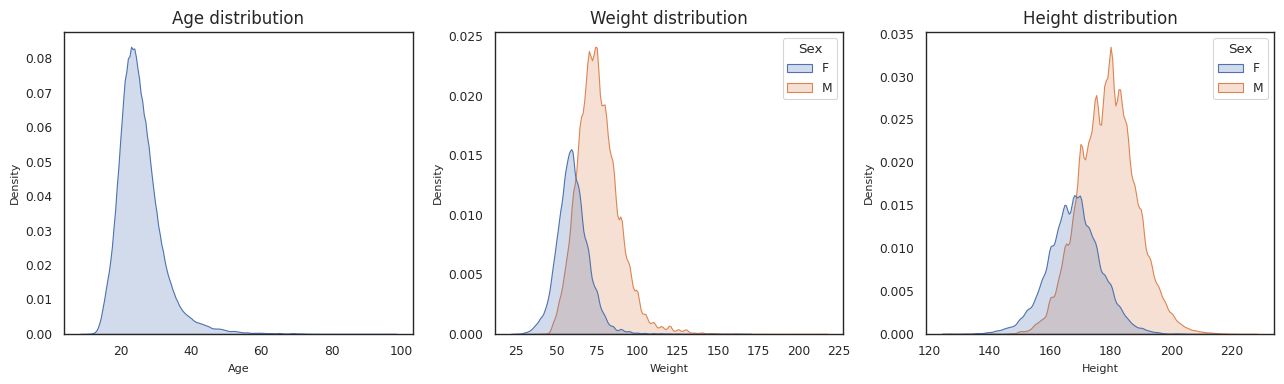

In [15]:
# Testing for skewness in Age, Weight and Height
plot_dists(athlete_events_df)

In [16]:
# Gets upper and lower limits of a range of values using the interquartile range
def get_outlier_limits_iqr(df, col_name):
    first_quartile = df[col_name].quantile(0.25)
    third_quartile = df[col_name].quantile(0.75)
    iqr = third_quartile - first_quartile
    return first_quartile - 1.5 * iqr, third_quartile + 1.5 * iqr

In [17]:
# Plots boxplots for Age and Weight
def plot_boxplots(df):
    fig, ax = plt.subplots(1, 2, figsize=(7, 4))

    sns.boxplot(df["Age"], ax=ax[0])
    ax[0].set_title("Age")
    sns.boxplot(x="Sex", y="Weight", data=df, ax=ax[1])
    ax[1].set_title("Weight")
    fig.tight_layout()
    plt.show()

In [18]:
# Outlier analysis
def outlier_analysis(df, col_name, limit_fun):
    lower_limit, upper_limit = limit_fun(df, col_name)

    print(f"Outliers below the limit: {lower_limit}")
    outliers_1 = df[df[col_name] < lower_limit].sort_values(by=[col_name])
    display(outliers_1.head(5))

    print(f"\nOutliers above the limit: {upper_limit}")
    outliers_2 = df[df[col_name] > upper_limit].sort_values(by=[col_name])
    display(outliers_2.tail(5))

    print("\nPercentage of outliers for {}: {:.2}%\n".format(col_name, (len(outliers_1) + len(outliers_2))/len(df)*100))

The boxplot below shows that there's a significant number of outliers for both height and weight. Removing all these outliers based on the IQR rule would lead to remove all the variability from the data which would in turn lead to incorrect analyses. Thus we will have to remove specific cases of outliers for each field or correct them if necessary.

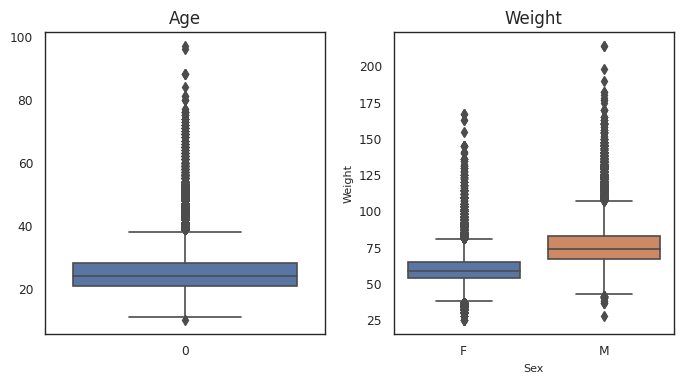

In [19]:
# Outlier analysis for Age and Weight
plot_boxplots(athlete_events_df)

**I) Age**

With regards to age, the only records we'll remove are the ones that have an age that exceed 84. According to olympedia.org, the oldest athlete in the olympics database is 84 years old, thus it is reasonable to remove these records.

In [20]:
# Outlier analysis for age
outlier_analysis(athlete_events_df, "Age", get_outlier_limits_iqr)

Outliers below the limit: 10.5


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
142882,71691,Dimitrios Loundras,M,10.0,NaN,NaN,Ethnikos Gymnastikos Syllogos,GRE,1896 Summer,1896,Summer,Athens,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Bronze



Outliers above the limit: 38.5


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
60861,31173,Thomas Cowperthwait Eakins,M,88.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
60862,31173,Thomas Cowperthwait Eakins,M,88.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
60863,31173,Thomas Cowperthwait Eakins,M,88.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
98118,49663,Winslow Homer,M,96.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
257054,128719,John Quincy Adams Ward,M,97.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",None



Percentage of outliers for Age: 3.8%



Below are the records that have been removed from the dataset. These records consist of athletes who had their works submitted posthumously (after their death).

In [21]:
# Removing any record that contains an age that exceeds 84
removed_records = athlete_events_df[athlete_events_df["Age"] > 84]
athlete_events_df = athlete_events_df[(athlete_events_df["Age"].isnull()) | (athlete_events_df["Age"] <= 84)]
display(removed_records)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
60861,31173,Thomas Cowperthwait Eakins,M,88.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
60862,31173,Thomas Cowperthwait Eakins,M,88.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
60863,31173,Thomas Cowperthwait Eakins,M,88.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
98118,49663,Winslow Homer,M,96.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",None
257054,128719,John Quincy Adams Ward,M,97.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",None


**II) Weight**

**Male Weights**

We will not remove any records based on weights as they are all valid. Instead we'll correct the record for 'Albert Ferdinand "Al" Zerhusen' as there seems to have been a typo when his weight was recorded (it's supposed to be 82kg instead of 28kg). Also, there is no athlete in the olympics database with the name 'tienne Nol Henri Vandernotte', so we will remove all instances of that record.

In [22]:
# Outlier analysis for male weights
outlier_analysis(athlete_events_df[athlete_events_df["Sex"] == "M"], "Weight", get_outlier_limits_iqr)

Outliers below the limit: 43.0


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
268586,134370,"Albert Ferdinand ""Al"" Zerhusen",M,24.0,183.0,28.0,United States,USA,1956 Summer,1956,Summer,Melbourne Stockholm,Football,Football Men's Football,None
249803,125092,tienne Nol Henri Vandernotte,M,12.0,NaN,37.0,France,FRA,1936 Summer,1936,Summer,Berlin,Rowing,Rowing Men's Coxed Pairs,Bronze
225700,113413,Alaeddin Soueidan,M,13.0,148.0,37.0,Syria,SYR,1984 Summer,1984,Summer,Los Angeles,Diving,Diving Men's Platform,None
249804,125092,tienne Nol Henri Vandernotte,M,12.0,NaN,37.0,France,FRA,1936 Summer,1936,Summer,Berlin,Rowing,Rowing Men's Coxed Fours,Bronze
75351,38251,Wayne Bruce Gammon,M,14.0,155.0,38.0,Australia,AUS,1964 Summer,1964,Summer,Tokyo,Rowing,Rowing Men's Coxed Pairs,None



Outliers above the limit: 107.0


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
237039,118869,"Christopher J. ""Chris"" Taylor",M,22.0,196.0,182.0,United States,USA,1972 Summer,1972,Summer,Munich,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",None
75031,38075,Marek Galiski,M,29.0,200.0,190.0,Poland,POL,1980 Summer,1980,Summer,Moscow,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",None
205467,103159,Aytami Ruano Vega,M,27.0,200.0,198.0,Spain,ESP,2004 Summer,2004,Summer,Athens,Judo,Judo Men's Heavyweight,None
23155,12177,"Ricardo Blas, Jr.",M,21.0,183.0,214.0,Guam,GUM,2008 Summer,2008,Summer,Beijing,Judo,Judo Men's Heavyweight,None
23156,12177,"Ricardo Blas, Jr.",M,25.0,183.0,214.0,Guam,GUM,2012 Summer,2012,Summer,London,Judo,Judo Men's Heavyweight,None



Percentage of outliers for Weight: 1.5%



In [23]:
# Rectifying the weight record and removing non-existent athlete
athlete_events_df.loc[athlete_events_df["ID"] == 134370, "Weight"] = 82
athlete_events_df = athlete_events_df[athlete_events_df["ID"] != 125092]

**Female Weights**

Similarly, we won't be removing any outliers in this case as well.

In [24]:
# Outlier analysis for female weights
outlier_analysis(athlete_events_df[athlete_events_df["Sex"] == "F"], "Weight", get_outlier_limits_iqr)

Outliers below the limit: 37.5


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
40854,21049,Choi Myong-Hui,F,14.0,135.0,25.0,North Korea,PRK,1980 Summer,1980,Summer,Moscow,Gymnastics,Gymnastics Women's Balance Beam,None
40853,21049,Choi Myong-Hui,F,14.0,135.0,25.0,North Korea,PRK,1980 Summer,1980,Summer,Moscow,Gymnastics,Gymnastics Women's Uneven Bars,None
40852,21049,Choi Myong-Hui,F,14.0,135.0,25.0,North Korea,PRK,1980 Summer,1980,Summer,Moscow,Gymnastics,Gymnastics Women's Horse Vault,None
40851,21049,Choi Myong-Hui,F,14.0,135.0,25.0,North Korea,PRK,1980 Summer,1980,Summer,Moscow,Gymnastics,Gymnastics Women's Floor Exercise,None
40850,21049,Choi Myong-Hui,F,14.0,135.0,25.0,North Korea,PRK,1980 Summer,1980,Summer,Moscow,Gymnastics,Gymnastics Women's Team All-Around,None



Outliers above the limit: 81.5


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
148349,74435,Holley Mangold,F,22.0,173.0,155.0,United States,USA,2012 Summer,2012,Summer,London,Weightlifting,Weightlifting Women's Super-Heavyweight,None
196342,98570,Samah Ramadan Mohamed,F,30.0,186.0,163.0,Egypt,EGY,2008 Summer,2008,Summer,Beijing,Judo,Judo Women's Heavyweight,None
196341,98570,Samah Ramadan Mohamed,F,26.0,186.0,163.0,Egypt,EGY,2004 Summer,2004,Summer,Athens,Judo,Judo Women's Heavyweight,None
124420,62843,Olha Vasylivna Korobka,F,22.0,181.0,167.0,Ukraine,UKR,2008 Summer,2008,Summer,Beijing,Weightlifting,Weightlifting Women's Super-Heavyweight,Silver
124419,62843,Olha Vasylivna Korobka,F,18.0,181.0,167.0,Ukraine,UKR,2004 Summer,2004,Summer,Athens,Weightlifting,Weightlifting Women's Super-Heavyweight,None



Percentage of outliers for Weight: 3.1%



**III) Height**

As seen previously, the height distribution is normal for both genders. Therefore, we will set outlier bounds by fitting a normal distribution to the data i.e outliers are values that lie beyond 3 standard deviation units from the mean.

In [25]:
# Computes upper and lower limits using the standard deviation and mean
def get_outlier_limits_std(df, col_name):
    upper_limit = df[col_name].mean() + 3 * df[col_name].std()
    lower_limit = df[col_name].mean() - 3 * df[col_name].std()
    return lower_limit, upper_limit

In [26]:
# Function to plot shaded distribution with outlier indicators
def plot_dists_std(df, col_name):
    plt.figure(figsize=(10, 5))
    mean, var, std = df[col_name].mean(), df[col_name].std()**2, df[col_name].std()
    ax = sns.kdeplot(df[col_name], shade=True)

    N = len(df[col_name].unique())

    x1 = np.linspace(mean - 4*std, mean - 3*std, N)
    x2 = np.linspace(mean - 3*std, mean + 3*std, N)
    x3 = np.linspace(mean + 3*std, mean + 4*std, N)
    x = np.concatenate((x1, x2, x3))
    x = np.where((mean - 3*std < x) & (x < mean + 3*std), np.nan, x)
    y = norm.pdf(x, mean, std)
    ax.fill_between(x, y, alpha=0.5)

    plt.xlabel(col_name)
    plt.ylabel("Density")

    plt.show()

**Female Heights**

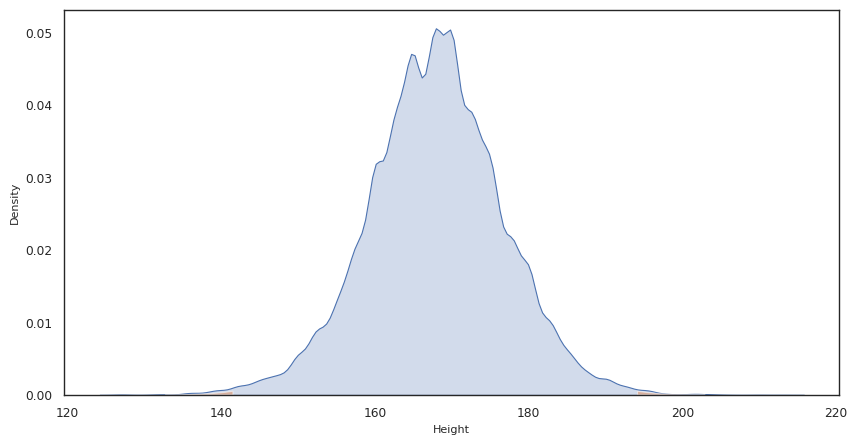

In [27]:
# Distribution plot for female heights
athlete_events_df_f = athlete_events_df[athlete_events_df["Sex"] == "F"]
plot_dists_std(athlete_events_df_f, "Height")

The plot above shows the values identied as outliers in the orange shade. In a normal distribution 99.7% of values lie within 3 standard deviation units of the mean. This distributionc almost exhibits that property as there are only 0.52% outliers. All the extreme outlier records are valid and represent participants recorded in the olympics database. For that reason, we won't be removing any outliers.

In [28]:
# Identifying outliers
outlier_analysis(athlete_events_df[athlete_events_df["Sex"] == "F"], "Height", get_outlier_limits_std)

Outliers below the limit: 141.50415229797363


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
29335,15150,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Floor Exercise,None
29333,15150,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Individual All-Around,None
29336,15150,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Horse Vault,None
29334,15150,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Team All-Around,None
29337,15150,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Uneven Bars,None



Outliers above the limit: 194.1753215789795


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
39497,20323,Chen Yuefang,F,21.0,205.0,104.0,China,CHN,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Women's Basketball,Bronze
258204,129295,Wei Wei,F,22.0,206.0,90.0,China,CHN,2012 Summer,2012,Summer,London,Basketball,Basketball Women's Basketball,None
216268,108551,Ujana Semjonova,F,28.0,210.0,128.0,Soviet Union,RUS,1980 Summer,1980,Summer,Moscow,Basketball,Basketball Women's Basketball,Gold
216267,108551,Ujana Semjonova,F,24.0,210.0,128.0,Soviet Union,RUS,1976 Summer,1976,Summer,Montreal,Basketball,Basketball Women's Basketball,Gold
60623,31045,"Magorzata Teresa ""Margo"" Dydek (-Twigg)",F,26.0,213.0,100.0,Poland,POL,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Women's Basketball,None



Percentage of outliers for Height: 0.52%



**Male Heights**

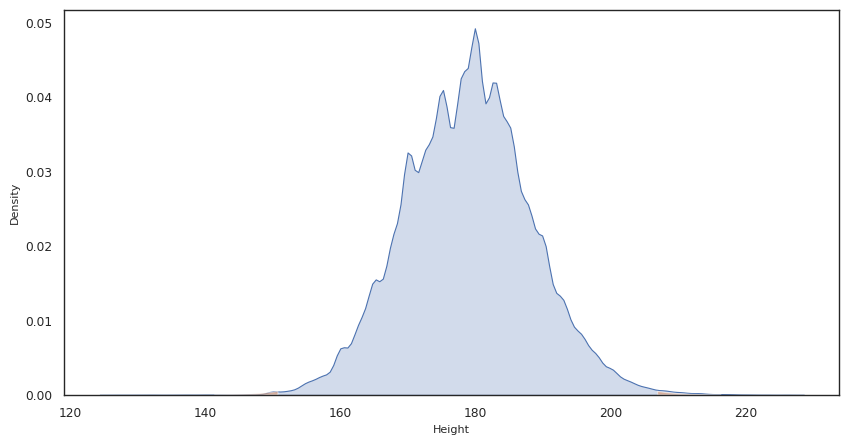

In [29]:
# Distribution plot for male heights
athlete_events_df_m = athlete_events_df[athlete_events_df["Sex"] == "M"]
plot_dists_std(athlete_events_df_m, "Height")

This distribution also satisfies the normal distribution property as there are only 0.36% outliers. Similar to the previous case, we will not remove any outliers.

In [30]:
# Identifying outliers
outlier_analysis(athlete_events_df[athlete_events_df["Sex"] == "M"], "Height", get_outlier_limits_std)

Outliers below the limit: 150.76881790161133


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
164821,82769,Lyton Levison Mphande,M,25.0,127.0,62.0,Malawi,MAW,1988 Summer,1988,Summer,Seoul,Boxing,Boxing Men's Light-Welterweight,None
180615,90772,Helman Palije,M,21.0,128.0,74.0,Malawi,MAW,1988 Summer,1988,Summer,Seoul,Boxing,Boxing Men's Middleweight,None
159934,80255,Salvador Miranda,M,22.0,130.0,51.0,Nicaragua,NCA,1972 Summer,1972,Summer,Munich,Boxing,Boxing Men's Flyweight,None
220270,110638,Boston Simbeye,M,28.0,130.0,67.0,Malawi,MAW,1988 Summer,1988,Summer,Seoul,Boxing,Boxing Men's Welterweight,None
3510,2003,Said Mubarak Marhoon Al-Khatry,M,NaN,132.0,66.0,Oman,OMA,1984 Summer,1984,Summer,Los Angeles,Shooting,"Shooting Men's Rapid-Fire Pistol, 25 metres",None



Outliers above the limit: 206.9504508972168


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
207375,104059,Arvydas Romas Sabonis,M,31.0,223.0,122.0,Lithuania,LTU,1996 Summer,1996,Summer,Atlanta,Basketball,Basketball Men's Basketball,Bronze
32376,16639,Tommy Loren Burleson,M,20.0,223.0,102.0,United States,USA,1972 Summer,1972,Summer,Munich,Basketball,Basketball Men's Basketball,Silver
265042,132627,Yao Ming,M,27.0,226.0,141.0,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,None
265040,132627,Yao Ming,M,20.0,226.0,141.0,China,CHN,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,None
265041,132627,Yao Ming,M,23.0,226.0,141.0,China,CHN,2004 Summer,2004,Summer,Athens,Basketball,Basketball Men's Basketball,None



Percentage of outliers for Height: 0.36%



### C) Imputing missing values

In [31]:
# Calculates percentage of missing values for a field
def missing_vals_percent(df, field):
  number_of_missing_ages = df[[field]].isnull().sum().sum()
  print(f"Percentage of missing values = {round(number_of_missing_ages/len(df)*100, 1)}%\n")

In [32]:
# Exploration function (returns df with matching field values)
def exploration_func(df, cat_fields, cat):
    cond_format = '{0[0]} == {0[1]}'.format
    return df.query(' & '.join(cond_format((arg[0], f"\"{arg[1]}\"")) if type(arg[1]) is str else cond_format(arg) for arg in zip(cat_fields, cat)))

In [33]:
# Returns the number of rows with missing values in all the specified fields and an array of missing value analyses for each category
def missing_vals_analysis(df, cat_fields, missing_field):
  categories = list(df.groupby(by=cat_fields, sort=False).groups.keys())

  # Check for groups with missing for all the records
  log = []
  for cat in categories:
    # filter out a group matching each category (iteratively)
    group = exploration_func(df, cat_fields, cat)

    if (pd.isnull(group[missing_field])).all(): # All the records have missing values
      print(f"Found group with missing values: {cat}")
    else:
      # extract descriptive stats for the missing field in each group
      group_mean = round(group[missing_field].mean())
      group_min = round(group[missing_field].min())
      group_max = round(group[missing_field].max())

      # Compute the percentage of missing values in this group
      no_missing_values = group[[missing_field]].isnull().sum().sum()
      missing_values_prop = round((no_missing_values/len(group))*100, 1)

      if no_missing_values > 0:
        log.append(f"{cat}; mean = {group_mean}, min = {group_min}, max = {group_max}, missing values percentage = {missing_values_prop}%")

  return log


**I) Age**



The following cell calculates the propotion of missing values for age in each event group, where an event is distinguished by year, season and sport. From the output we can draw the following insights:

* There's a noticeable trend where older events (from the years 1896 and 1900) have a significantly higher percentage of missing data compared to more recent years (e.g., 1992 onwards). This pattern might be due to several factors such as poorer record-keeping standards, loss of records over time, or less stringent participant documentation during the earlier years of the events.
* By contrast, events in the 1990s and beyond have missing data percentages generally below 1%, reflecting advancements in data collection and retention, likely due to digitization and improved administrative processes.

In [34]:
# Filling in age
# - Missing values analysis
missing_vals_percent(athlete_events_df, "Age")
log = missing_vals_analysis(athlete_events_df, ['Year', 'Season', 'Sport'], 'Age')
for l in log[:20] + log[-20:]: print(l)

Percentage of missing values = 3.2%

(1896, 'Summer', 'Athletics'); mean = 22, min = 17, max = 34, missing values percentage = 34.9%
(1896, 'Summer', 'Cycling'); mean = 23, min = 18, max = 36, missing values percentage = 53.7%
(1896, 'Summer', 'Fencing'); mean = 22, min = 18, max = 29, missing values percentage = 60.0%
(1896, 'Summer', 'Gymnastics'); mean = 24, min = 10, max = 31, missing values percentage = 24.7%
(1896, 'Summer', 'Shooting'); mean = 31, min = 21, max = 40, missing values percentage = 70.8%
(1896, 'Summer', 'Swimming'); mean = 19, min = 18, max = 20, missing values percentage = 61.1%
(1896, 'Summer', 'Tennis'); mean = 21, min = 17, max = 25, missing values percentage = 34.8%
(1896, 'Summer', 'Weightlifting'); mean = 22, min = 21, max = 26, missing values percentage = 40.0%
(1896, 'Summer', 'Wrestling'); mean = 23, min = 21, max = 26, missing values percentage = 40.0%
(1900, 'Summer', 'Archery'); mean = 36, min = 24, max = 50, missing values percentage = 18.8%
(1900, 'S

Since the ealier events are more prone to missing values than the rest, removing them would lead to a significant loss of information. Thus we will impute the missing ages by replacing them with the mean of their respective event groups. On the other hand, imputing values for all the groups could introduce bias for groups where the age gap is significant. Thus we will use the missingness threshold of 50% i.e we will only impute values for groups where the percentage of missing values exceeds 50%.

In [35]:
# Identiying event groups with more than 50% missing values
missing_ratio = athlete_events_df.groupby(['Year', 'Season', 'Sport'])['Age'].apply(lambda x: x.isnull().sum()/len(x))
missing_groups = missing_ratio[missing_ratio > 0.5]
display(missing_groups)

Year  Season  Sport     
1896  Summer  Cycling       0.536585
              Fencing       0.600000
              Shooting      0.707692
              Swimming      0.611111
1900  Summer  Cycling       0.663043
              Fencing       0.577287
              Football      0.542857
              Gymnastics    0.755556
              Sailing       0.507143
              Water Polo    0.509434
1904  Summer  Lacrosse      0.527778
              Tug-Of-War    0.566667
1908  Summer  Boxing        0.523810
Name: Age, dtype: float64

In [36]:
# Imputing missing values in each group
def impute_age(row):
    if pd.isnull(row['Age']) and ((row['Year'], row['Season'], row['Sport']) in missing_groups.keys()):
        return round(athlete_events_df.query("Year == @row.Year & Season == @row.Season & Sport == @row.Sport")["Age"].mean())
    else:
        return row['Age']


athlete_events_df['Age'] = athlete_events_df.apply(impute_age, axis = 1)

This method removed 0.2% of the missing values from the groups we identified.

In [37]:
missing_vals_percent(athlete_events_df, "Age")

Percentage of missing values = 3.0%



**II) Weights**

We now perform a similar analysis with weights. This time we have identied groups with entirely missing values. Since we don't have enough information about what could have possibly caused this we will omit these groups (interestingly these groups are from the earlier years of the olympics). An event group is now distinguished by gender, year, season and sport since weights differ by gender. Unlike with age we can impute weight values for all the groups with missingness of less than 100%. We also do this by replacing the missing values with the means of their corresponding groups.

In [38]:
# Filling in weights
# - Missing values analysis
missing_vals_percent(athlete_events_df, "Weight")
log = missing_vals_analysis(athlete_events_df, ['Sex', 'Year', 'Season', 'Sport'], 'Weight')
print()
for l in log[:20] + log[-20:]: print(l)

Percentage of missing values = 22.8%

Found group with missing values: ('F', 1900, 'Summer', 'Croquet')
Found group with missing values: ('F', 1900, 'Summer', 'Equestrianism')
Found group with missing values: ('F', 1900, 'Summer', 'Golf')
Found group with missing values: ('F', 1900, 'Summer', 'Sailing')
Found group with missing values: ('F', 1900, 'Summer', 'Tennis')
Found group with missing values: ('F', 1904, 'Summer', 'Archery')
Found group with missing values: ('F', 1908, 'Summer', 'Archery')
Found group with missing values: ('F', 1908, 'Summer', 'Figure Skating')
Found group with missing values: ('F', 1908, 'Summer', 'Motorboating')
Found group with missing values: ('F', 1908, 'Summer', 'Sailing')
Found group with missing values: ('F', 1908, 'Summer', 'Tennis')
Found group with missing values: ('F', 1912, 'Summer', 'Diving')
Found group with missing values: ('F', 1912, 'Summer', 'Swimming')
Found group with missing values: ('F', 1912, 'Summer', 'Tennis')
Found group with missing v

In [39]:
# - Imputation (replacing missing weights for each event by average weight of the participants)
athlete_events_df['Weight'].fillna(athlete_events_df.groupby(['Sex', 'Year', 'Season', 'Sport'], sort=False)['Weight'].transform('mean'),
                                inplace=True)
missing_vals_percent(athlete_events_df, "Weight")

Percentage of missing values = 2.2%



**III) Height**

For height, we have also identified groups with missing values. Similar to the previous case will omit them. We will again perform the same method of imputation for the height values.

In [40]:
# Filling in heights
# - Missing values analysis
missing_vals_percent(athlete_events_df, "Height")
log = missing_vals_analysis(athlete_events_df, ['Sex', 'Year', 'Season', 'Sport'], 'Height')
print()
for l in log[:20] + log[-20:]: print(l)

Percentage of missing values = 21.8%

Found group with missing values: ('F', 1900, 'Summer', 'Croquet')
Found group with missing values: ('F', 1900, 'Summer', 'Equestrianism')
Found group with missing values: ('F', 1900, 'Summer', 'Golf')
Found group with missing values: ('F', 1900, 'Summer', 'Sailing')
Found group with missing values: ('F', 1900, 'Summer', 'Tennis')
Found group with missing values: ('F', 1904, 'Summer', 'Archery')
Found group with missing values: ('F', 1908, 'Summer', 'Archery')
Found group with missing values: ('F', 1908, 'Summer', 'Figure Skating')
Found group with missing values: ('F', 1908, 'Summer', 'Motorboating')
Found group with missing values: ('F', 1908, 'Summer', 'Sailing')
Found group with missing values: ('F', 1908, 'Summer', 'Tennis')
Found group with missing values: ('F', 1912, 'Summer', 'Diving')
Found group with missing values: ('F', 1912, 'Summer', 'Swimming')
Found group with missing values: ('F', 1912, 'Summer', 'Tennis')
Found group with missing v

In [41]:
# - Imputation (replacing missing heights for each event by average height of the participants)
athlete_events_df['Height'].fillna(athlete_events_df.groupby(['Sex', 'Year', 'Season', 'Sport'], sort=False)['Height'].transform('mean'),
                                inplace=True)
missing_vals_percent(athlete_events_df, "Height")

Percentage of missing values = 0.8%



For the remaining records that have only height values, we will estimate their weights using the Devine formula to compute ideal body weight.

In [42]:
# Using the Devine formula to fill in for missing weights (ideal body weight for adults)
athlete_events_df['Weight'] = athlete_events_df.apply(
    lambda row:  row['Weight']
    if pd.notnull(row['Weight']) or pd.isnull(row['Height']) or row['Age'] < 18
    else (50 + 0.9 * (row['Height'] - 152.4)
    if row['Sex'] == 'M'
    else 45.5 + 0.9 * (row['Height'] - 152.4)), axis=1
)

The percentage of missing weight values decreased by a significant amount after applying this method.

In [43]:
# Missing weight values
missing_vals_percent(athlete_events_df, "Weight")

Percentage of missing values = 0.6%



In [44]:
# Save final datasets
athlete_events_df.to_csv(f"{PREFIX}/cleaned_athlete_events.csv", index=False)
country_defs_df.to_csv(f"{PREFIX}/cleaned_country_defs.csv", index=False)

# **3.2 By Country Analysis**

In [45]:
# reading through dataframes
cleaned_athlete_events =  pd.read_csv(paths['cleaned_athlete_events'])
cleaned_country_defs = pd.read_csv(paths['cleaned_country_defs'])

In [46]:
#display country_defs data
cleaned_country_defs.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [47]:
#Creating a new csv file called countriies.csv

# Extract the unique values from the NOC column
#nocs = cleaned_athlete_events['NOC'].unique()

# Create a new DataFrame with the NOC values and the desired columns
#new_df = pd.DataFrame({'NOC': nocs})

# Writing  the new DataFrame to a CSV file
#new_df.to_csv('countries.csv', index=False)



In [48]:
# Load the athlete_def dataset into a pandas DataFrame
#df = pd.read_csv('cleaned_athlete_def.csv')

# Group the data by country/NOC
grouped_data = cleaned_athlete_events.groupby('NOC')

# Create an empty list to store the data rows
data = []

# Iterate over each country/NOC
for noc, group in grouped_data:
    # Calculate the number of golds, silvers, and bronzes
    golds = group[group['Medal'] == 'Gold'].shape[0]
    silvers = group[group['Medal'] == 'Silver'].shape[0]
    bronzes = group[group['Medal'] == 'Bronze'].shape[0]

    # Calculate the total number of participations
    participations = group.shape[0]
    #print(participations)

    # Calculate the mean, maximum, and minimum weights and heights
    mean_weight = group['Weight'].mean()
    max_weight = group['Weight'].max()
    min_weight = group['Weight'].min()
    mean_height = group['Height'].mean()
    max_height = group['Height'].max()
    min_height = group['Height'].min()

    # Calculate the fraction of athletes of each gender
    male_fraction = group[group['Sex'] == 'M'].shape[0] / group.shape[0]
    female_fraction = group[group['Sex'] == 'F'].shape[0] / group.shape[0]

    # Calculate the number of sports each country has medaled and participated in
    medaled_sports = group[group['Medal'] != 'None']['Sport'].nunique()
    participated_sports = group['Sport'].nunique()

    # Getting region for NOC
    region = list(cleaned_country_defs.query('NOC == @noc')["region"])[0]

    # Create a data row for the country
    if region:
        row = [noc, region, golds, silvers, bronzes, participations, mean_weight, max_weight, min_weight, mean_height, max_height, min_height, male_fraction, female_fraction, medaled_sports, participated_sports]

    # Append the data row to the list
    data.append(row)

# Define the header row
header = ['NOC', 'region', 'Golds', 'Silvers', 'Bronzes', 'Participations', 'Mean Weight', 'Max Weight', 'Min Weight', 'Mean Height', 'Max Height', 'Min Height', 'Male Fraction', 'Female Fraction', 'Medaled Sports', 'Participated Sports']

# Write the data to the CSV file
with open(PREFIX + '/countries.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(data)

print("CSV file created successfully.")

CSV file created successfully.


In [49]:
#Displaying the countries data that we just created
New_Data=pd.read_csv(PREFIX + '/countries.csv')
New_Data

,NOC,region,Golds,Silvers,Bronzes,Participations,Mean Weight,Max Weight,Min Weight,Mean Height,Max Height,Min Height,Male Fraction,Female Fraction,Medaled Sports,Participated Sports
0,AFG,Afghanistan,0,0,2,126,70.921849,111.000000,48.0,173.122696,186.00000,156.0,0.960317,0.039683,1,7
1,AHO,Curacao,0,1,0,79,75.286746,120.000000,52.0,176.613044,193.00000,152.0,0.848101,0.151899,1,13
2,ALB,Albania,0,0,0,70,71.779534,130.000000,45.0,173.405349,195.00000,159.0,0.614286,0.385714,0,8
3,ALG,Algeria,5,4,8,551,69.935861,125.000000,45.0,175.546123,200.00000,146.0,0.829401,0.170599,3,22
4,AND,Andorra,0,0,0,169,70.792707,90.000000,49.0,173.751821,189.00000,160.0,0.751479,0.248521,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,VIN,Saint Vincent,0,0,0,42,69.465613,82.000000,55.0,178.184550,187.34435,157.0,0.738095,0.261905,0,2
207,WIF,Trinidad,0,0,5,20,72.150000,100.000000,58.0,178.000000,189.00000,151.0,1.000000,0.000000,1,5
208,YEM,Yemen,0,0,0,48,65.281986,83.535973,48.0,170.458235,186.71097,155.0,0.916667,0.083333,0,7
209,ZAM,Zambia,0,1,1,183,66.617215,95.000000,48.0,173.501196,190.00000,150.0,0.896175,0.103825,2,8


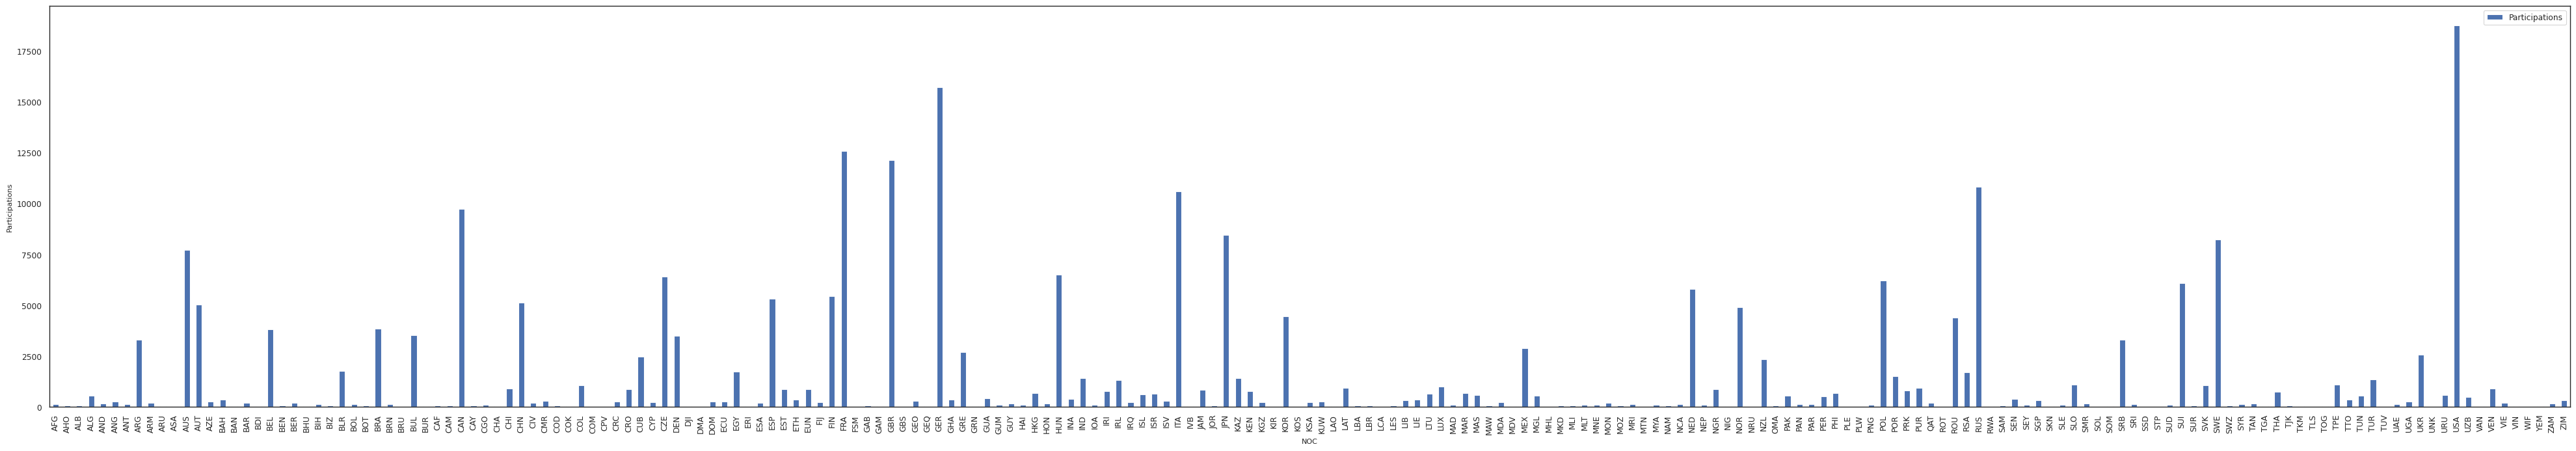

In [50]:
# df_teams_countries_disciplines = New_Data   \
#     .groupby(by="NOC").agg({'Participations':'count'} )  \
#     .reset_index().sort_values(by='Participations', ascending=False)

ax = New_Data.plot.bar(x='NOC', y='Participations', xlabel = 'NOC', ylabel='Participations', figsize=(50,8))

In [51]:
geo_data = osgeo.ogr.Open(PREFIX + "/TM_WORLD_BORDERS-0.3.shp")
geo_data

<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x78134a189e90> >

In [52]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(f"{type(df_world)}, {df_world.geometry.name}")
print(df_world.head())
print(df_world.geometry.geom_type.value_counts())

<class 'geopandas.geodataframe.GeoDataFrame'>, geometry
       pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
Polygon         148
MultiPolygon     29
dtype: int64


In [53]:
world_1 = df_world.merge(New_Data, left_on='iso_a3', right_on='NOC', how='right')
world_1.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,NOC,region,Golds,Silvers,...,Mean Weight,Max Weight,Min Weight,Mean Height,Max Height,Min Height,Male Fraction,Female Fraction,Medaled Sports,Participated Sports
0,38041754.0,Asia,Afghanistan,AFG,19291.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",AFG,Afghanistan,0,0,...,70.921849,111.0,48.0,173.122696,186.0,156.0,0.960317,0.039683,1,7
1,NaN,NaN,NaN,NaN,NaN,None,AHO,Curacao,0,1,...,75.286746,120.0,52.0,176.613044,193.0,152.0,0.848101,0.151899,1,13
2,2854191.0,Europe,Albania,ALB,15279.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",ALB,Albania,0,0,...,71.779534,130.0,45.0,173.405349,195.0,159.0,0.614286,0.385714,0,8
3,NaN,NaN,NaN,NaN,NaN,None,ALG,Algeria,5,4,...,69.935861,125.0,45.0,175.546123,200.0,146.0,0.829401,0.170599,3,22
4,NaN,NaN,NaN,NaN,NaN,None,AND,Andorra,0,0,...,70.792707,90.0,49.0,173.751821,189.0,160.0,0.751479,0.248521,0,12


#### a) Medal type each country has won.

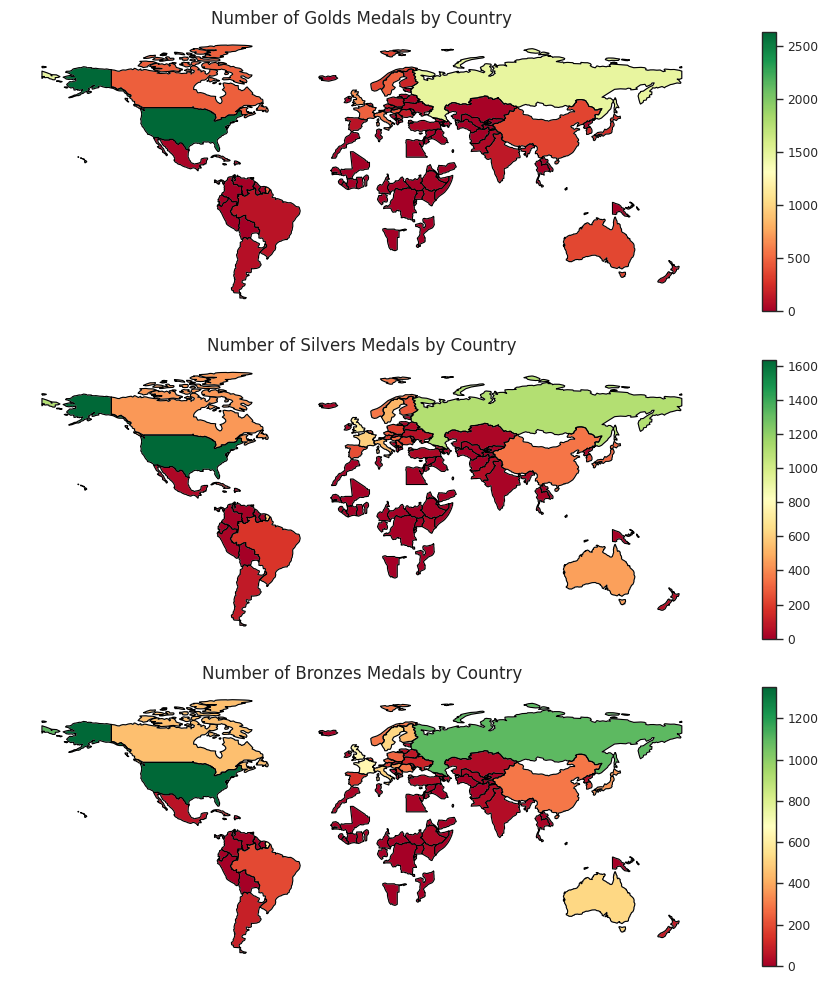

In [54]:
# Create a choropleth map for each medal type (Gold, Silver, Bronze)
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
medal_types = ['Golds', 'Silvers', 'Bronzes']

for i, medal in enumerate(medal_types):
    ax = axes[i]
    world_1.boundary.plot(ax=ax, linewidth=0.8, color='black')
    world_1.plot(column=medal, cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title(f'Number of {medal} Medals by Country')
    ax.axis('off')

plt.tight_layout()
plt.show()



The majority of all medals types is consistently earned by Russian nations. In sharp contrast, African and South American countries display the lowest tally of gold medals, with the highest count plateauing around 600.
</br>

Mirroring the gold medal trend, the countries that excel in gold medals also claim a significant portion of silver medals. North American countries, in particular, make a strong showing in both gold and silver medal standings.
</br>

In alignment with the patterns observed for gold and silver medals, North American and European countries also dominate the count for bronze medals. This pattern suggests that North American nations boast the most extensive collection of gold, silver, and bronze medals in comparison to any other continent. Furthermore, Australia secures a noteworthy number of both silver and bronze medals. The distribution of bronze medals appears to follow a typical pattern across National Olympic Committees (NOCs) globally.

For b) and c)

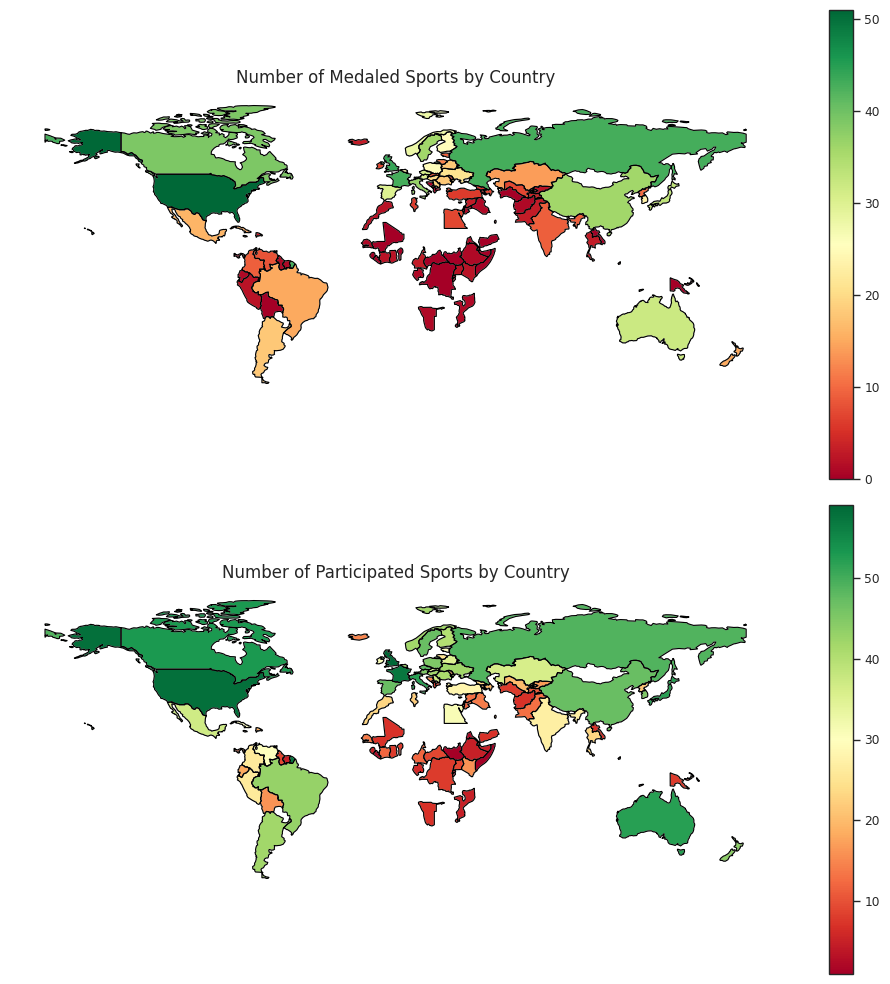

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
types = ['Medaled Sports', 'Participated Sports']

for i, col in enumerate(types):
    ax = axes[i]
    world_1.boundary.plot(ax=ax, linewidth=0.8, color='black')
    world_1.plot(column=col, cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title(f'Number of {col} by Country')
    ax.axis('off')

plt.tight_layout()
plt.show()


North American nations have consistently excelled in winning sports medals, with Australia and specific European countries closely following suit. In contrast, African nations secure the fewest sports medals, and South American counterparts also achieve lower medal counts overall.
</br>

An analysis spanning from 1896 to 2016 reveals that there were as many as 50 different sports in which countries participated. Despite South American countries' relatively modest performance in the Olympics, they exhibit a strong presence across a wide range of sports. Conversely, the impressive performance of South American countries, as demonstrated in earlier visualizations, is complemented by their active involvement in diverse sports. This trend is also observed in Australia and various European countries. In contrast, African countries appear to have limited participation, corresponding to their comparatively modest performance in the Olympics over the years

# **3.3 By Sport Analysis**


create a new csv file called events.csv

In [56]:
events_analysis = cleaned_athlete_events

In [57]:
# Create a new DataFrame to  store the data
events_df = pd.DataFrame()

In [58]:
grouped_events = events_analysis.groupby(['Sport','NOC'])

In [59]:
grouped_events.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.00000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
1,2,A Lamusi,M,23.0,170.00000,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
2,3,Gunnar Nielsen Aaby,M,24.0,174.91667,75.181816,Denmark,DEN,1920 Summer,1920,Summer,Antwerp,Football,Football Men's Football,None
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.00000,82.000000,Netherlands,NED,1988 Winter,1988,Winter,Seoul,Speed Skating,Speed Skating Women's 500 metres,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268659,135259,Schirin Zorriasateiny,F,20.0,167.00000,55.000000,Norway,NOR,1984 Summer,1984,Summer,Los Angeles,Rhythmic Gymnastics,Rhythmic Gymnastics Women's Individual,None
268776,135295,Vladimir Zrni,M,26.0,176.00000,82.000000,Yugoslavia,SRB,1980 Summer,1980,Summer,Moscow,Weightlifting,Weightlifting Men's Light-Heavyweight,None
268980,135387,Nenad ugaj,M,29.0,177.00000,84.000000,Croatia,CRO,2012 Summer,2012,Summer,London,Wrestling,"Wrestling Men's Light-Heavyweight, Greco-Roman",None
268981,135388,Neven ugaj,M,29.0,177.00000,74.000000,Croatia,CRO,2012 Summer,2012,Summer,London,Wrestling,"Wrestling Men's Middleweight, Greco-Roman",None


In [60]:

data = []

# Iterate over each row by Sport
for sport, group in grouped_events:
    # Calculate the number of golds, silvers, and bronzes
    golds = group[group['Medal'] == 'Gold'].shape[0]
    silvers = group[group['Medal'] == 'Silver'].shape[0]
    bronzes = group[group['Medal'] == 'Bronze'].shape[0]

    # Calculate the total number of participations
    participations = group.shape[0]

    # Calculate the mean, maximum, and minimum weights and heights
    mean_weight = group['Weight'].mean()
    max_weight = group['Weight'].max()
    min_weight = group['Weight'].min()
    mean_height = group['Height'].mean()
    max_height = group['Height'].max()
    min_height = group['Height'].min()
    #Add the Age variable
    mean_age = group['Age'].mean()


    # Calculate the number of sports each country has medaled and participated in
    medaled_sports = group[group['Medal'].notna()]['Sport'].nunique()
    participated_sports = group['Sport'].nunique()


    #sport and country
    row_sport = sport[0]
    row_country = sport[1]

    # Create a data row for the country
    row = [row_sport, row_country, golds, silvers, bronzes, participations, mean_weight, max_weight, min_weight, mean_height, max_height, min_height,mean_age, medaled_sports, participated_sports]

    # Append the data row to the list
    data.append(row)

# Define the header row
header = ['Sport',' Country', 'Golds', 'Silvers', 'Bronzes', 'Participations', 'Mean Weight', 'Max Weight', 'Min Weight', 'Mean Height', 'Max Height', 'Min Height','Age' ,'Medaled Sports', 'Participated Sports']

# Write the data to the CSV file
with open(PREFIX + '/events.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(data)

print("CSV file created successfully.")

CSV file created successfully.


In [61]:
sport

('Wrestling', 'ZAM')

In [62]:
#Displaying the data  data that we just created

events_data=pd.read_csv(PREFIX + '/events.csv')
events_data

,Sport,Country,Golds,Silvers,Bronzes,Participations,Mean Weight,Max Weight,Min Weight,Mean Height,Max Height,Min Height,Age,Medaled Sports,Participated Sports
0,Aeronautics,SUI,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,1,1
1,Alpine Skiing,ALB,0,0,0,7,68.857143,74.000000,56.000000,175.142857,180.00000,163.0000,20.428571,1,1
2,Alpine Skiing,ALG,0,0,0,10,72.307373,80.013199,59.000000,174.560154,178.81519,167.3552,19.700000,1,1
3,Alpine Skiing,AND,0,0,0,105,71.632926,85.000000,59.650887,173.417078,187.00000,162.0000,20.447619,1,1
4,Alpine Skiing,ARG,0,0,0,262,68.477160,86.000000,48.000000,172.669888,190.00000,156.0000,20.950382,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,Wrestling,UZB,4,3,3,52,78.134615,130.000000,54.000000,174.365385,193.00000,158.0000,25.711538,1,1
3748,Wrestling,VEN,0,0,0,35,78.949798,130.000000,48.000000,171.034838,185.00000,147.0000,25.800000,1,1
3749,Wrestling,VIE,0,0,0,8,55.625000,68.000000,48.000000,161.500000,170.00000,153.0000,21.750000,1,1
3750,Wrestling,YEM,0,0,0,3,73.367355,78.102066,70.000000,168.463540,173.39062,165.0000,23.333333,1,1


In [63]:
dataf = events_data[['Sport','Mean Weight','Mean Height','Age']]

# Group by 'Sport' and sum the 'Participant' values
result = dataf.groupby('Sport')[['Mean Weight','Mean Height','Age']].mean(numeric_only=True).reset_index()
result.dropna(subset=['Mean Weight','Mean Height','Age'], inplace=True)

(a) Plot the mean weight against the mean height of participants in each
sport. Comment on your plot

Text(0.5, 1.0, 'Average height vs Weight per sport')

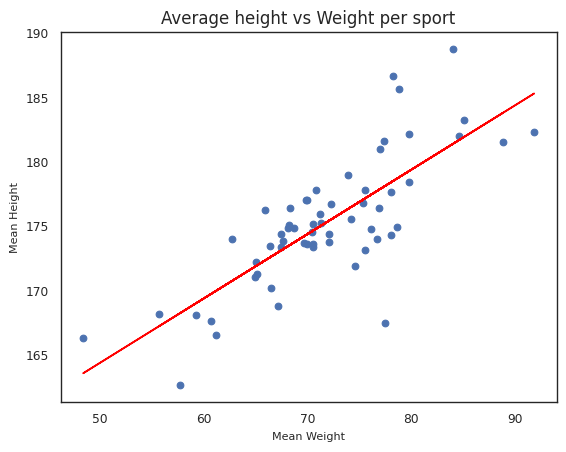

In [64]:
x =  result['Mean Weight']
y  = result['Mean Height']

coefficients = np.polyfit(x.values, y.values, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Create the line equation
line = slope * x + intercept

plt.scatter(x,y)
# Plot the line of best fit
plt.plot(x, line, label='Line of Best Fit', color='red')

# naming the x axis
plt.xlabel('Mean Weight')
# naming the y axis
plt.ylabel('Mean Height')
plt.title("Average height vs Weight per sport")

* The above scatter plot is a representation of the average height and weight where every point represents a different sport.
* There is a strong positive correlation between the weight and height for the different sports.
* There is less variability in the data meaning the data is less spread  around the line of best fit.
* As the average Height increases per sport then the weight also increasis by a simillar margin

(b) Repeat this for weight against age and height against age

Text(0.5, 1.0, 'Average weight vs Age per sport')

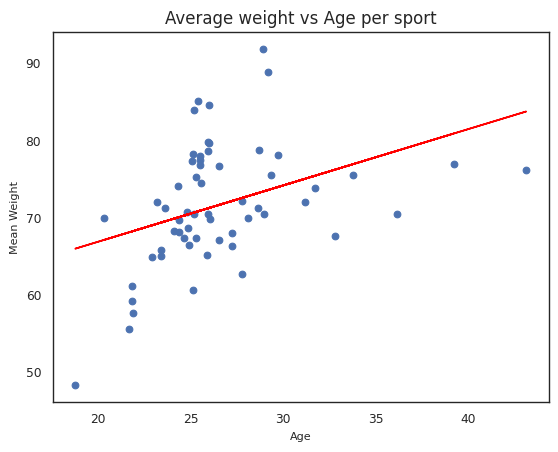

In [65]:
x =  result['Age']
y  = result['Mean Weight']


coefficients = np.polyfit(x.values, y.values, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Create the line equation
line = slope * x + intercept

plt.scatter(x,y)
# Plot the line of best fit
plt.plot(x, line, label='Line of Best Fit', color='red')

# naming the x axis
plt.xlabel('Age')
# naming the y axis
plt.ylabel('Mean Weight')
plt.title("Average weight vs Age per sport")

* The above scatter plot is a representation of the average height and age where every data point represents a different sport.
* There is a weak positive correlation between the height and age for the different sports.
* There is more variability in the data meaning the data is more spread to around the line of best fit.
* The average weight tends to increase with age but at a rate that is lower than the rate of increase in the age for every sport

Text(0.5, 1.0, 'Average Height vs Age per sport')

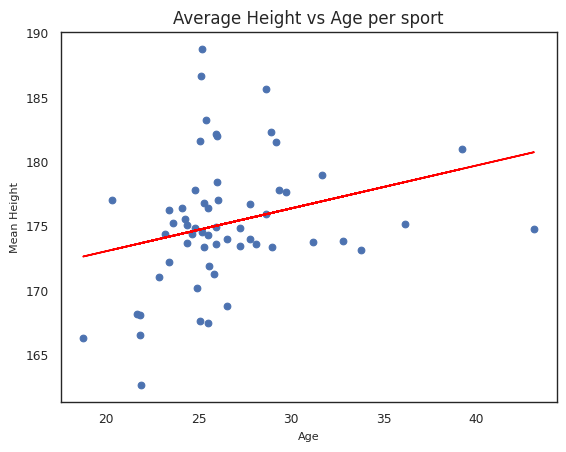

In [66]:
x =  result['Age']
y  = result['Mean Height']


coefficients = np.polyfit(x.values, y.values, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Create the line equation
line = slope * x + intercept

plt.scatter(x,y)
# Plot the line of best fit
plt.plot(x, line, label='Line of Best Fit', color='red')
plt.xlabel('Age')
# naming the y axis
plt.ylabel('Mean Height')
plt.title("Average Height vs Age per sport")

c) Draw a histogram of how many participations each event has had. Discuss
how you choose the number of buckets. Discuss the resulting histogram

In [67]:
sports_list = events_data['Sport'].unique()
temp = {}

In [68]:
dataf = events_data[['Sport','Participations']]

# Group by 'Sport' and sum the 'Participant' values
result = dataf.groupby('Sport')['Participations'].sum().reset_index()
result

,Sport,Participations
0,Aeronautics,1
1,Alpine Skiing,8829
2,Alpinism,25
3,Archery,2334
4,Art Competitions,3573
...,...,...
61,Tug-Of-War,138
62,Volleyball,3404
63,Water Polo,3846
64,Weightlifting,3915


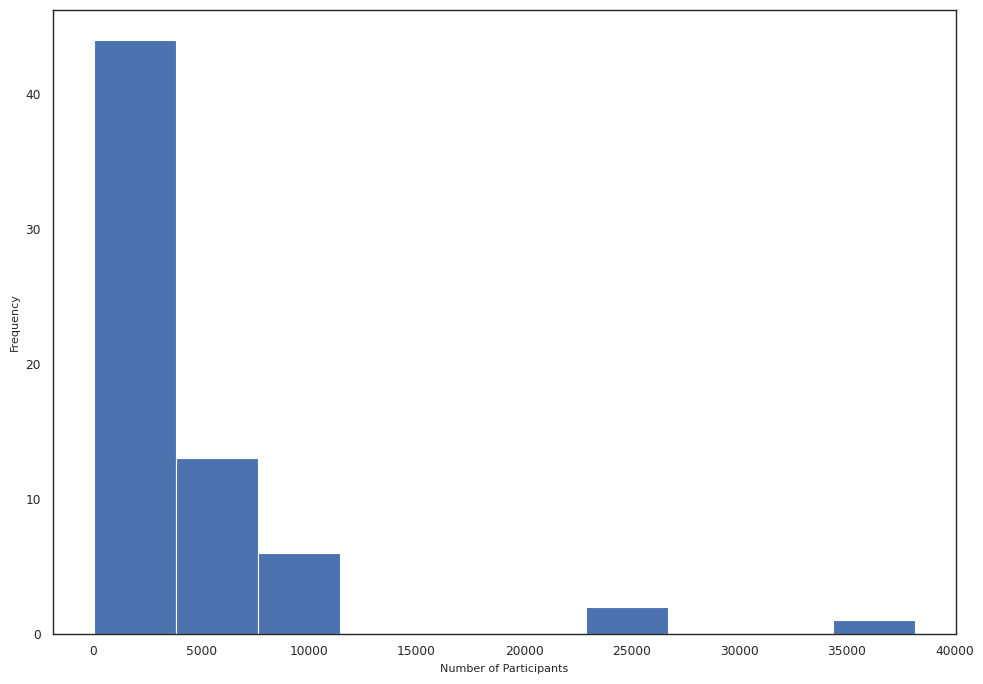

In [69]:
x = result['Participations']
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)

# use Sturges' formula to decide the number of bins
n = 66
num_bins = 1 + int(np.log2(n))
axs.hist(x, bins = 10)
# Adding extra features
plt.xlabel("Number of Participants")
plt.ylabel("Frequency")

# Show plot
plt.show()

Comments on the events results

###  3.4 Time series Analysis

In [70]:
 time_series_analysis = cleaned_athlete_events
 time_series_analysis

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.00000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
1,2,A Lamusi,M,23.0,170.00000,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
2,3,Gunnar Nielsen Aaby,M,24.0,174.91667,75.181816,Denmark,DEN,1920 Summer,1920,Summer,Antwerp,Football,Football Men's Football,None
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.00000,82.000000,Netherlands,NED,1988 Winter,1988,Winter,Seoul,Speed Skating,Speed Skating Women's 500 metres,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269371,135569,Andrzej ya,M,29.0,179.00000,89.000000,Poland-1,POL,1976 Winter,1976,Winter,Montreal,Luge,Luge Mixed (Men)'s Doubles,None
269372,135570,Piotr ya,M,27.0,176.00000,59.000000,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",None
269373,135570,Piotr ya,M,27.0,176.00000,59.000000,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",None
269374,135571,Tomasz Ireneusz ya,M,30.0,185.00000,96.000000,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,None


(a) Create a table called games.csv Each datapoint would be a games. Include
the total number of participants per games, the number of unique sports
and the number of unique events.

In [71]:
# Group by Games/Year/Season
grouped = time_series_analysis.groupby(['Games', 'Year', 'Season'])

# Create a new DataFrame to store the aggregated data
games_df = pd.DataFrame()

# Aggregate the required information
games_df['Total Participants'] = grouped['ID'].nunique()
games_df['Unique Sports'] = grouped['Sport'].nunique()
games_df['Unique Events'] = grouped['Event'].nunique()

# Reset the index for the new DataFrame
games_df.reset_index(inplace=True)


In [72]:
games_df.head()

,Games,Year,Season,Total Participants,Unique Sports,Unique Events
0,1896 Summer,1896,Summer,176,9,43
1,1900 Summer,1900,Summer,1224,20,90
2,1904 Summer,1904,Summer,650,18,95
3,1908 Summer,1908,Summer,2024,24,109
4,1912 Summer,1912,Summer,2409,17,107


(b) Draw a line graph for each of these variables. Use separate lines for the
summer and winter Olympics.

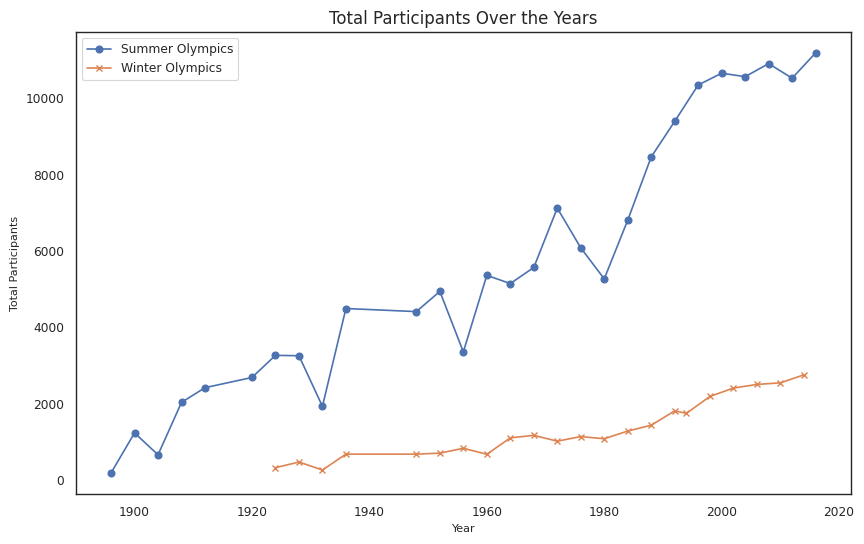

In [73]:
# Separate the data for Summer and Winter Olympics
summer_data = games_df[games_df['Season'] == 'Summer']
winter_data = games_df[games_df['Season'] == 'Winter']

# Draw line graph for 'Total Participants'
plt.figure(figsize=(10, 6))
plt.plot(summer_data['Year'], summer_data['Total Participants'], label='Summer Olympics', marker='o')
plt.plot(winter_data['Year'], winter_data['Total Participants'], label='Winter Olympics', marker='x')
plt.title('Total Participants Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Participants')
plt.legend()
plt.show()

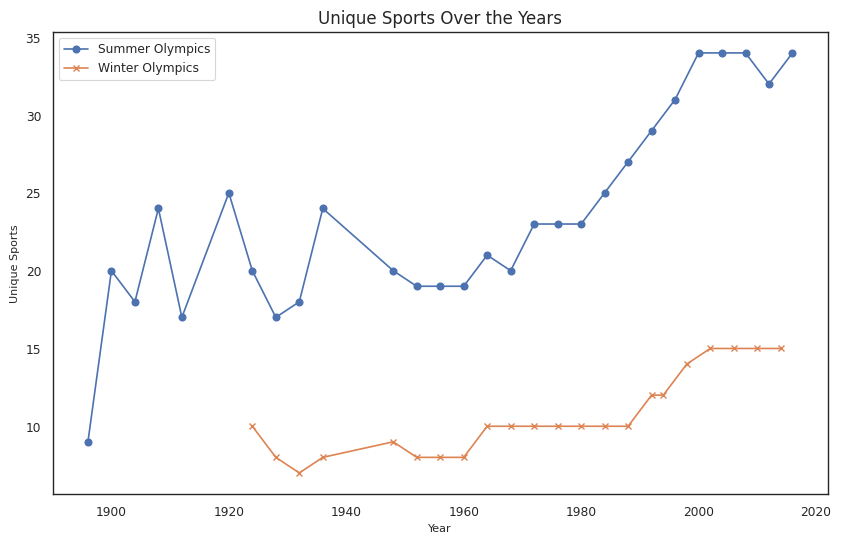

In [74]:
# Draw line graph for 'Unique Sports'
plt.figure(figsize=(10, 6))
plt.plot(summer_data['Year'], summer_data['Unique Sports'], label='Summer Olympics', marker='o')
plt.plot(winter_data['Year'], winter_data['Unique Sports'], label='Winter Olympics', marker='x')
plt.title('Unique Sports Over the Years')
plt.xlabel('Year')
plt.ylabel('Unique Sports')
plt.legend()
plt.show()

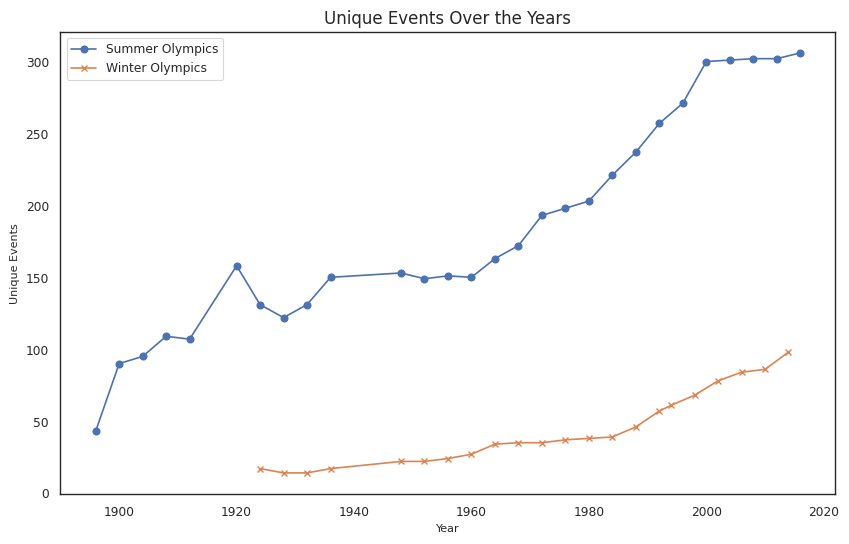

In [75]:
# Draw line graph for 'Unique Events'
plt.figure(figsize=(10, 6))
plt.plot(summer_data['Year'], summer_data['Unique Events'], label='Summer Olympics', marker='o')
plt.plot(winter_data['Year'], winter_data['Unique Events'], label='Winter Olympics', marker='x')
plt.title('Unique Events Over the Years')
plt.xlabel('Year')
plt.ylabel('Unique Events')
plt.legend()
plt.show()

(c) Comment on the results

### A Comprehensive Analysis of the Evolution of the Olympic Games: Scale, Complexity, and Anomalies

#### Introduction
The Olympic Games have significantly evolved since their inception in 1896, showcasing not only the world's finest athletes but also reflecting broader geopolitical and social trends. This report aims to comprehensively examine the trends in participation, the variety of sports, and events across the Summer and Winter Olympics, paying particular attention to anomalies and periods of significant change.

#### Trends in Participation
The overarching trend in the data clearly points to an increasing number of participants over the years, from 1896 to the most recent games in 2016. This trend is evident in both the Summer and Winter Olympics, although the magnitude of participation is substantially higher in the Summer Games. This increase likely reflects the growing global population, popularity and accessibility of the Olympic Games.

#### Diversity in Sports and Events
Parallel to the increase in participation is the growth in the number of unique sports and events featured. For context, the 1896 Summer Olympics included only 9 unique sports and 43 unique events. Fast-forward to the 2016 Summer Olympics, and these numbers have ballooned to 34 unique sports and 306 unique events. Such an increase underscores the evolving nature of the Games, reflecting both cultural trends and advances in athletic competition.

#### Seasonal Differences
A noteworthy observation is the significant scale difference between the Summer and Winter Olympics. The Summer Games generally feature more participants, sports, and events. This discrepancy likely arises from the broader variety of sports that can be accommodated in the summer and greater global accessibility to summer sports as opposed to winter sports.

#### The 1900 Anomaly
One intriguing outlier in the data is the 1900 Summer Olympics, which saw a sudden spike in both the number of participants and events, only to decline in the subsequent 1904 Games. This so-called '1900 Anomaly' warrants further investigation. A deep dive reveals multiple contributing factors:

- **Integration with the World's Fair:** The 1900 Games were held concurrently with the 1900 World’s Fair, attracting a diverse set of participants and allowing for a more extensive event lineup.
  
- **Unconventional Events:** Unique and one-time events such as automobile racing and ballooning were included.
  
- **Inclusion of Women:** For the first time, women participated in the Games, thereby increasing the number of athletes.

- **Global Participation:** Athletes from 26 different nations took part, marking a significant uptick from the 1896 Games.

These collective factors made the 1900 Games an exceptional case, illustrating how special circumstances can dramatically influence the metrics of participation and event variety.

#### Post-War and Cold War Impacts
The data indicates a marked increase in all observed metrics post-World War II, likely attributable to geopolitical stability and enhanced international cooperation. Additionally, the 1990s saw significant spikes, possibly due to the end of the Cold War and increased professional inclusion in the Games.

#### Recent Stabilization
In recent years, there has been a stabilization in the number of unique sports featured, possibly indicating a saturation point or a calculated move to focus on existing sports rather than incorporating new ones.

#### Conclusion
In summary, the Olympic Games have seen significant evolution over more than a century, influenced by a myriad of factors ranging from geopolitical changes to social trends. The data portrays a complex tapestry of growth and diversification, punctuated by unique anomalies and historical milestones.


**EXTRA VISUALIZATIONS**

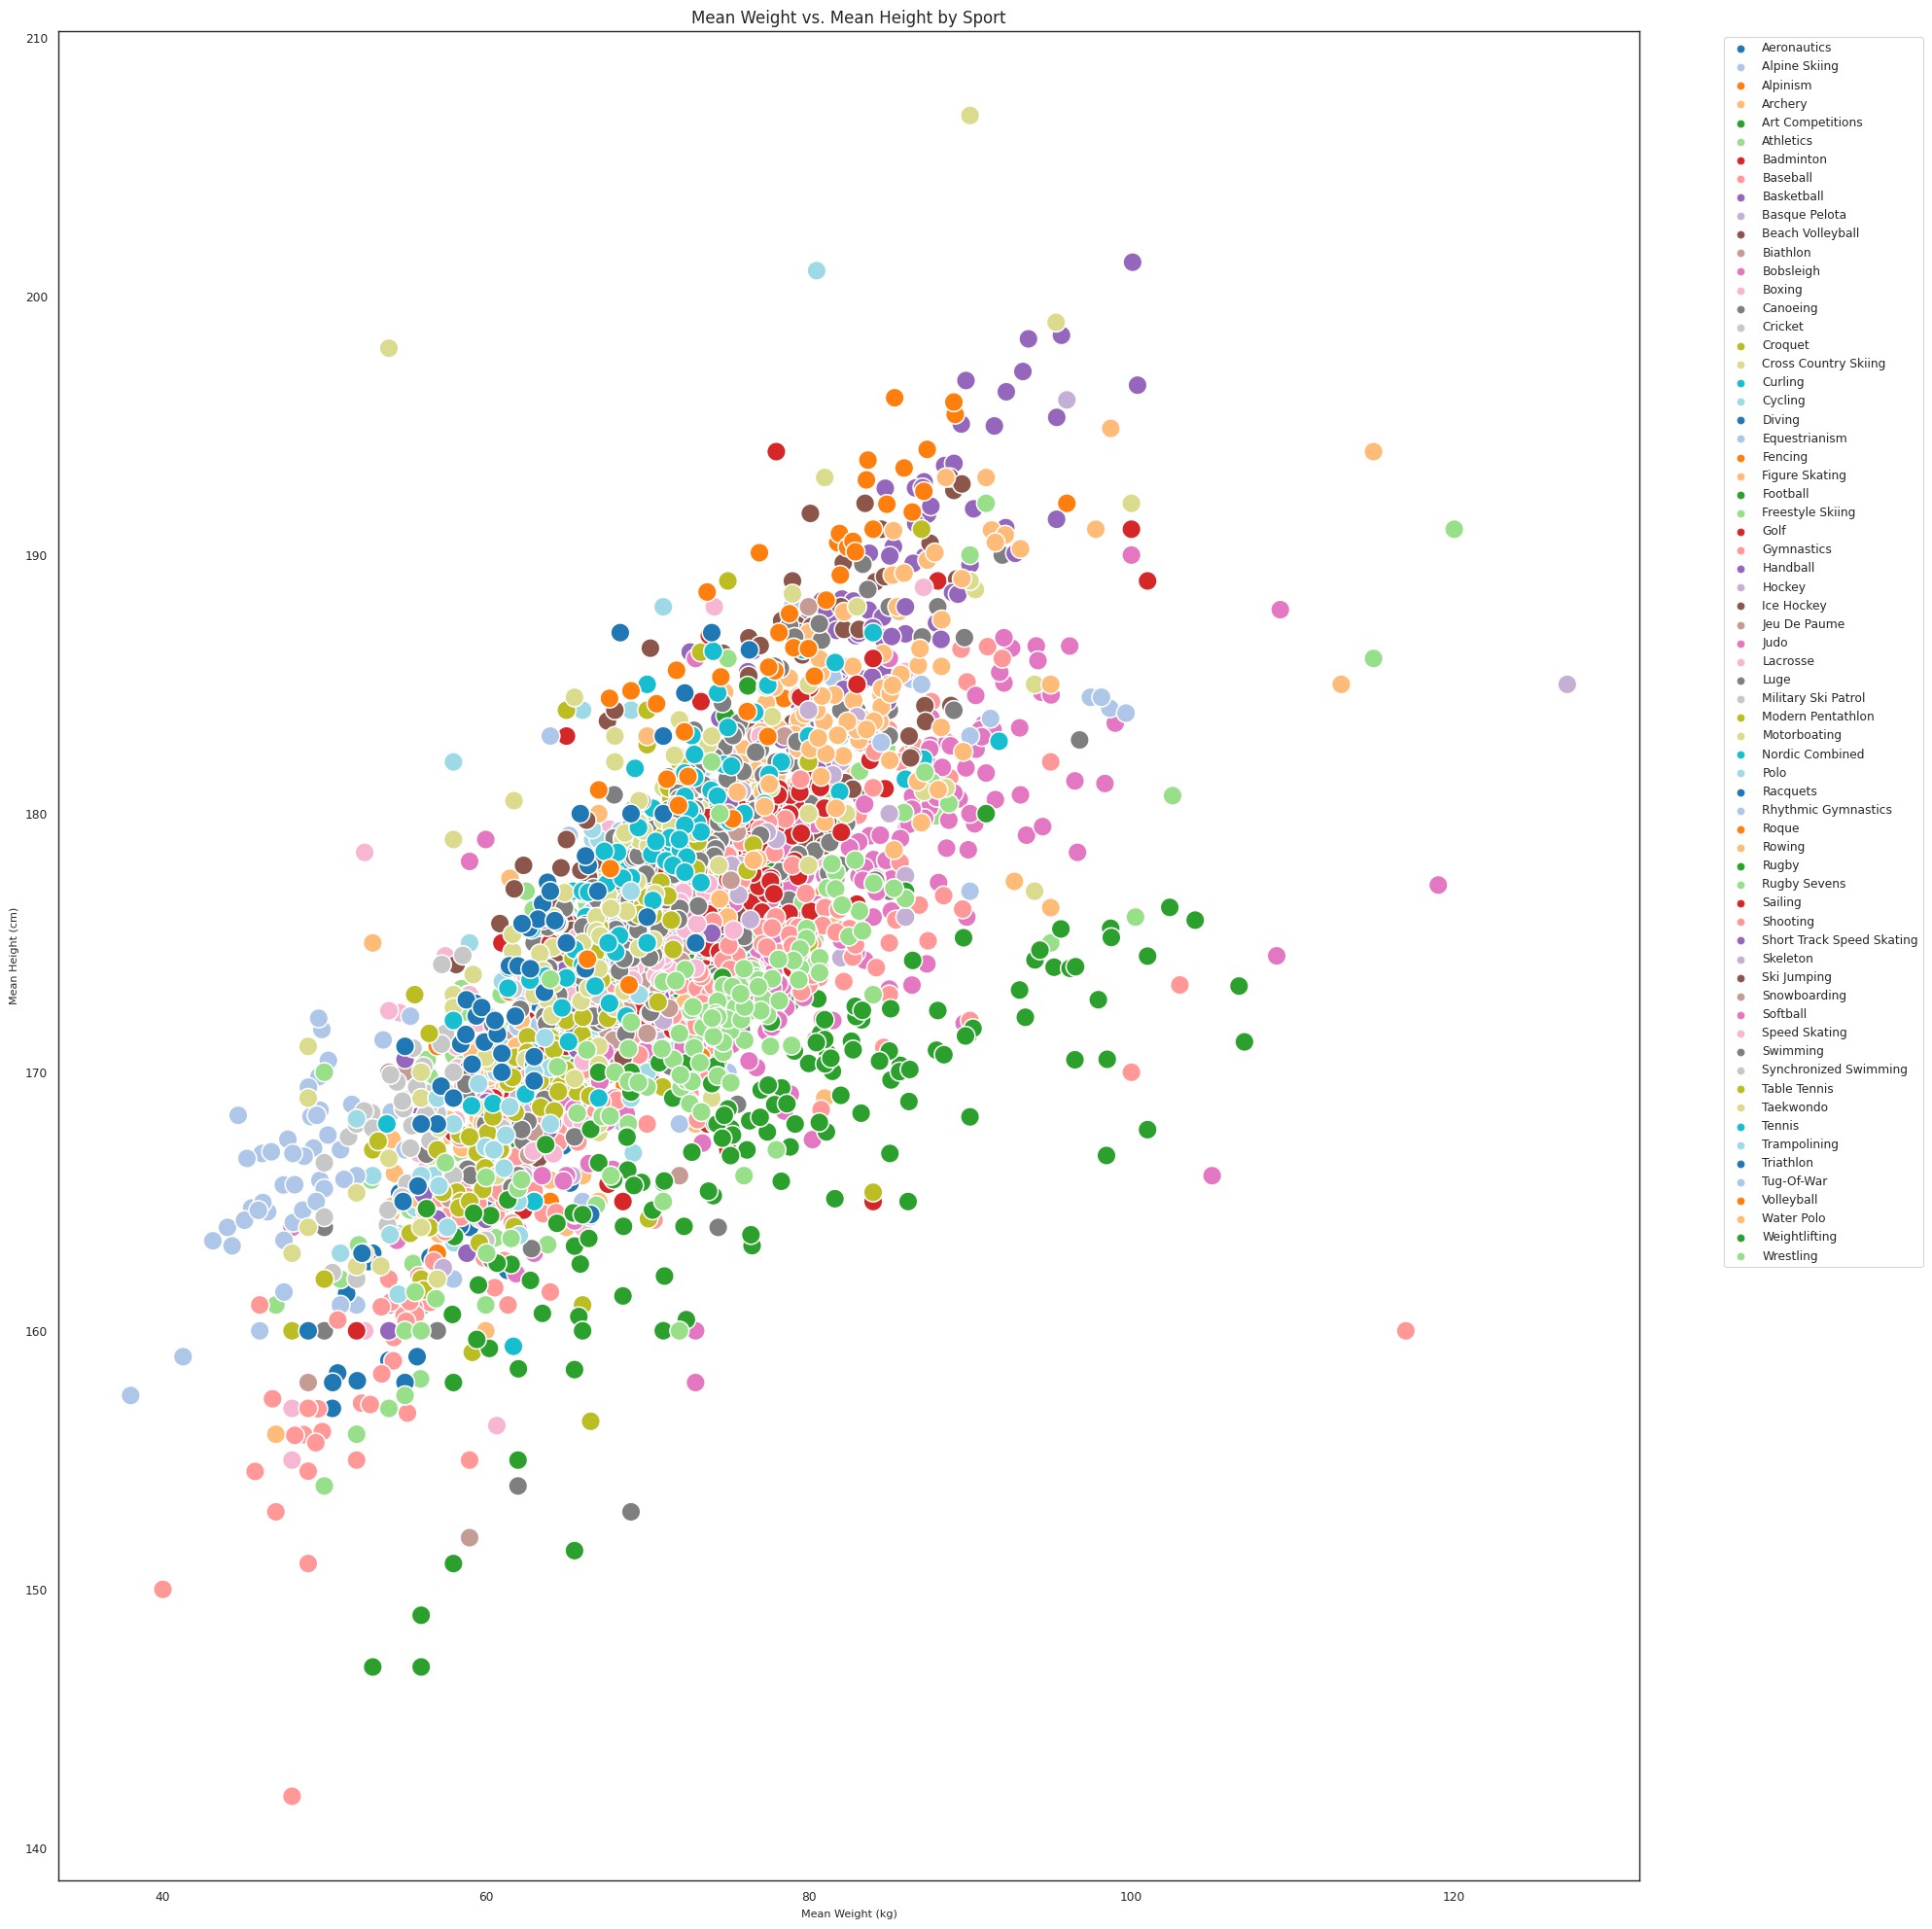

In [76]:
#plotting mean height vs mean weight by sports
plt.figure(figsize=(20, 20))
sns.scatterplot(data=events_data, x='Mean Weight', y='Mean Height', hue='Sport', palette='tab20', edgecolor='w', s=200)
plt.title('Mean Weight vs. Mean Height by Sport')
plt.xlabel('Mean Weight (kg)')
plt.ylabel('Mean Height (cm)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Age distribution**

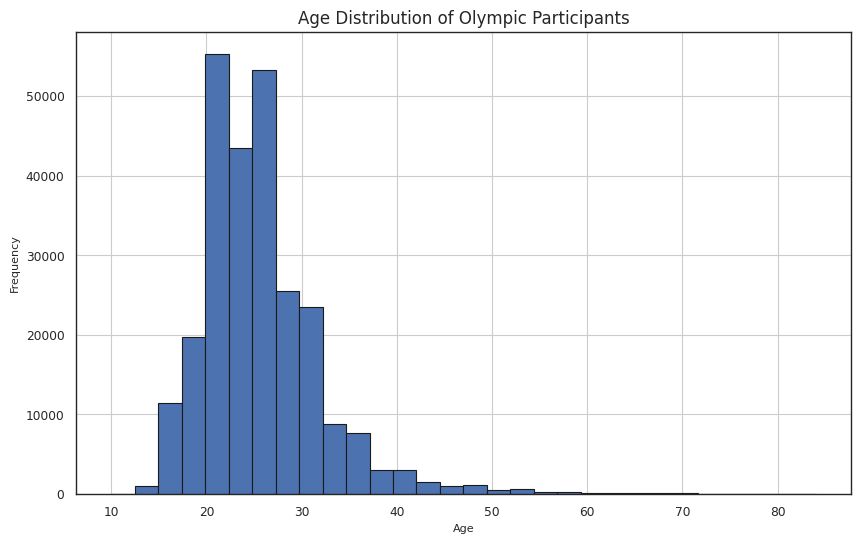

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(athlete_events_df['Age'], bins=30, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Olympic Participants')
plt.grid(True)
plt.show()